In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
data = pd.read_csv('forestfires.csv')

Колонки в датасете:

In [ ]:
data.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

Обзор содержащейся информации:

In [ ]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Датасет содержит следующие признаки:
* X - координата X пожара
* Y - координата Y пожара
* month - месяц пожара
* day - день недели пожара
* FFMC - индекс FFMC из системы FWI
* DMC - индекс DMC из системы FWI
* DC - индекс DC из системы FWI
* ISI - индекс ISI из системы FWI
* temp - температура
* RH - относительная влажность
* wind - скорость ветра
* rain - дождь
* area - площадь выгоревшего леса

Посмотрим основную информацию

In [ ]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# **1.EDA**

Посмотрим распределение целевой перемнной

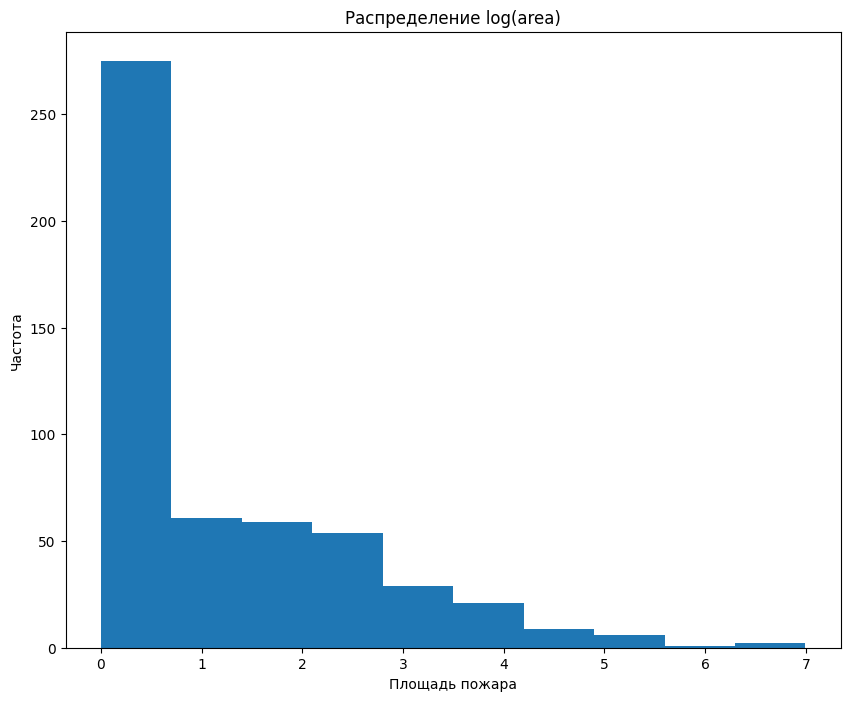

In [ ]:
plt.figure(figsize = (10, 8))
plt.title('Распределение log(area)')
plt.hist(np.log1p(data['area']))
plt.xlabel('Площадь пожара')
plt.ylabel('Частота')
plt.show()

Видим много нулевых значений в целевой переменной и редкие выбросы.

Посмотрим корреляцию целевой переменной с признаками

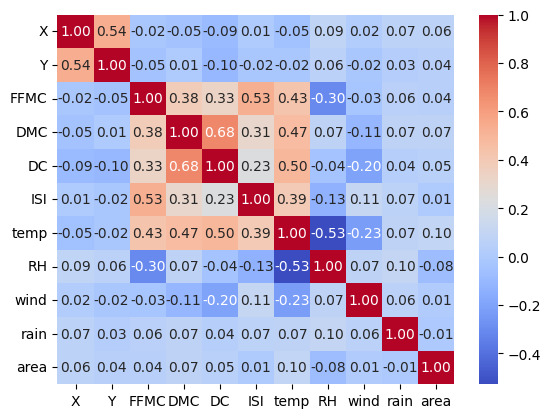

In [ ]:
data_corr = data.select_dtypes(exclude = 'object').corr()
sns.heatmap(data_corr, cmap = 'coolwarm', annot = True, fmt = '.2f' )
plt.show()

Посмотрим на взаимосвязь


1.   Площади пожара от месяца
2.   Площади пожара от климатических изменений (ветра, температуры и тп)
3. Распределение по регионам



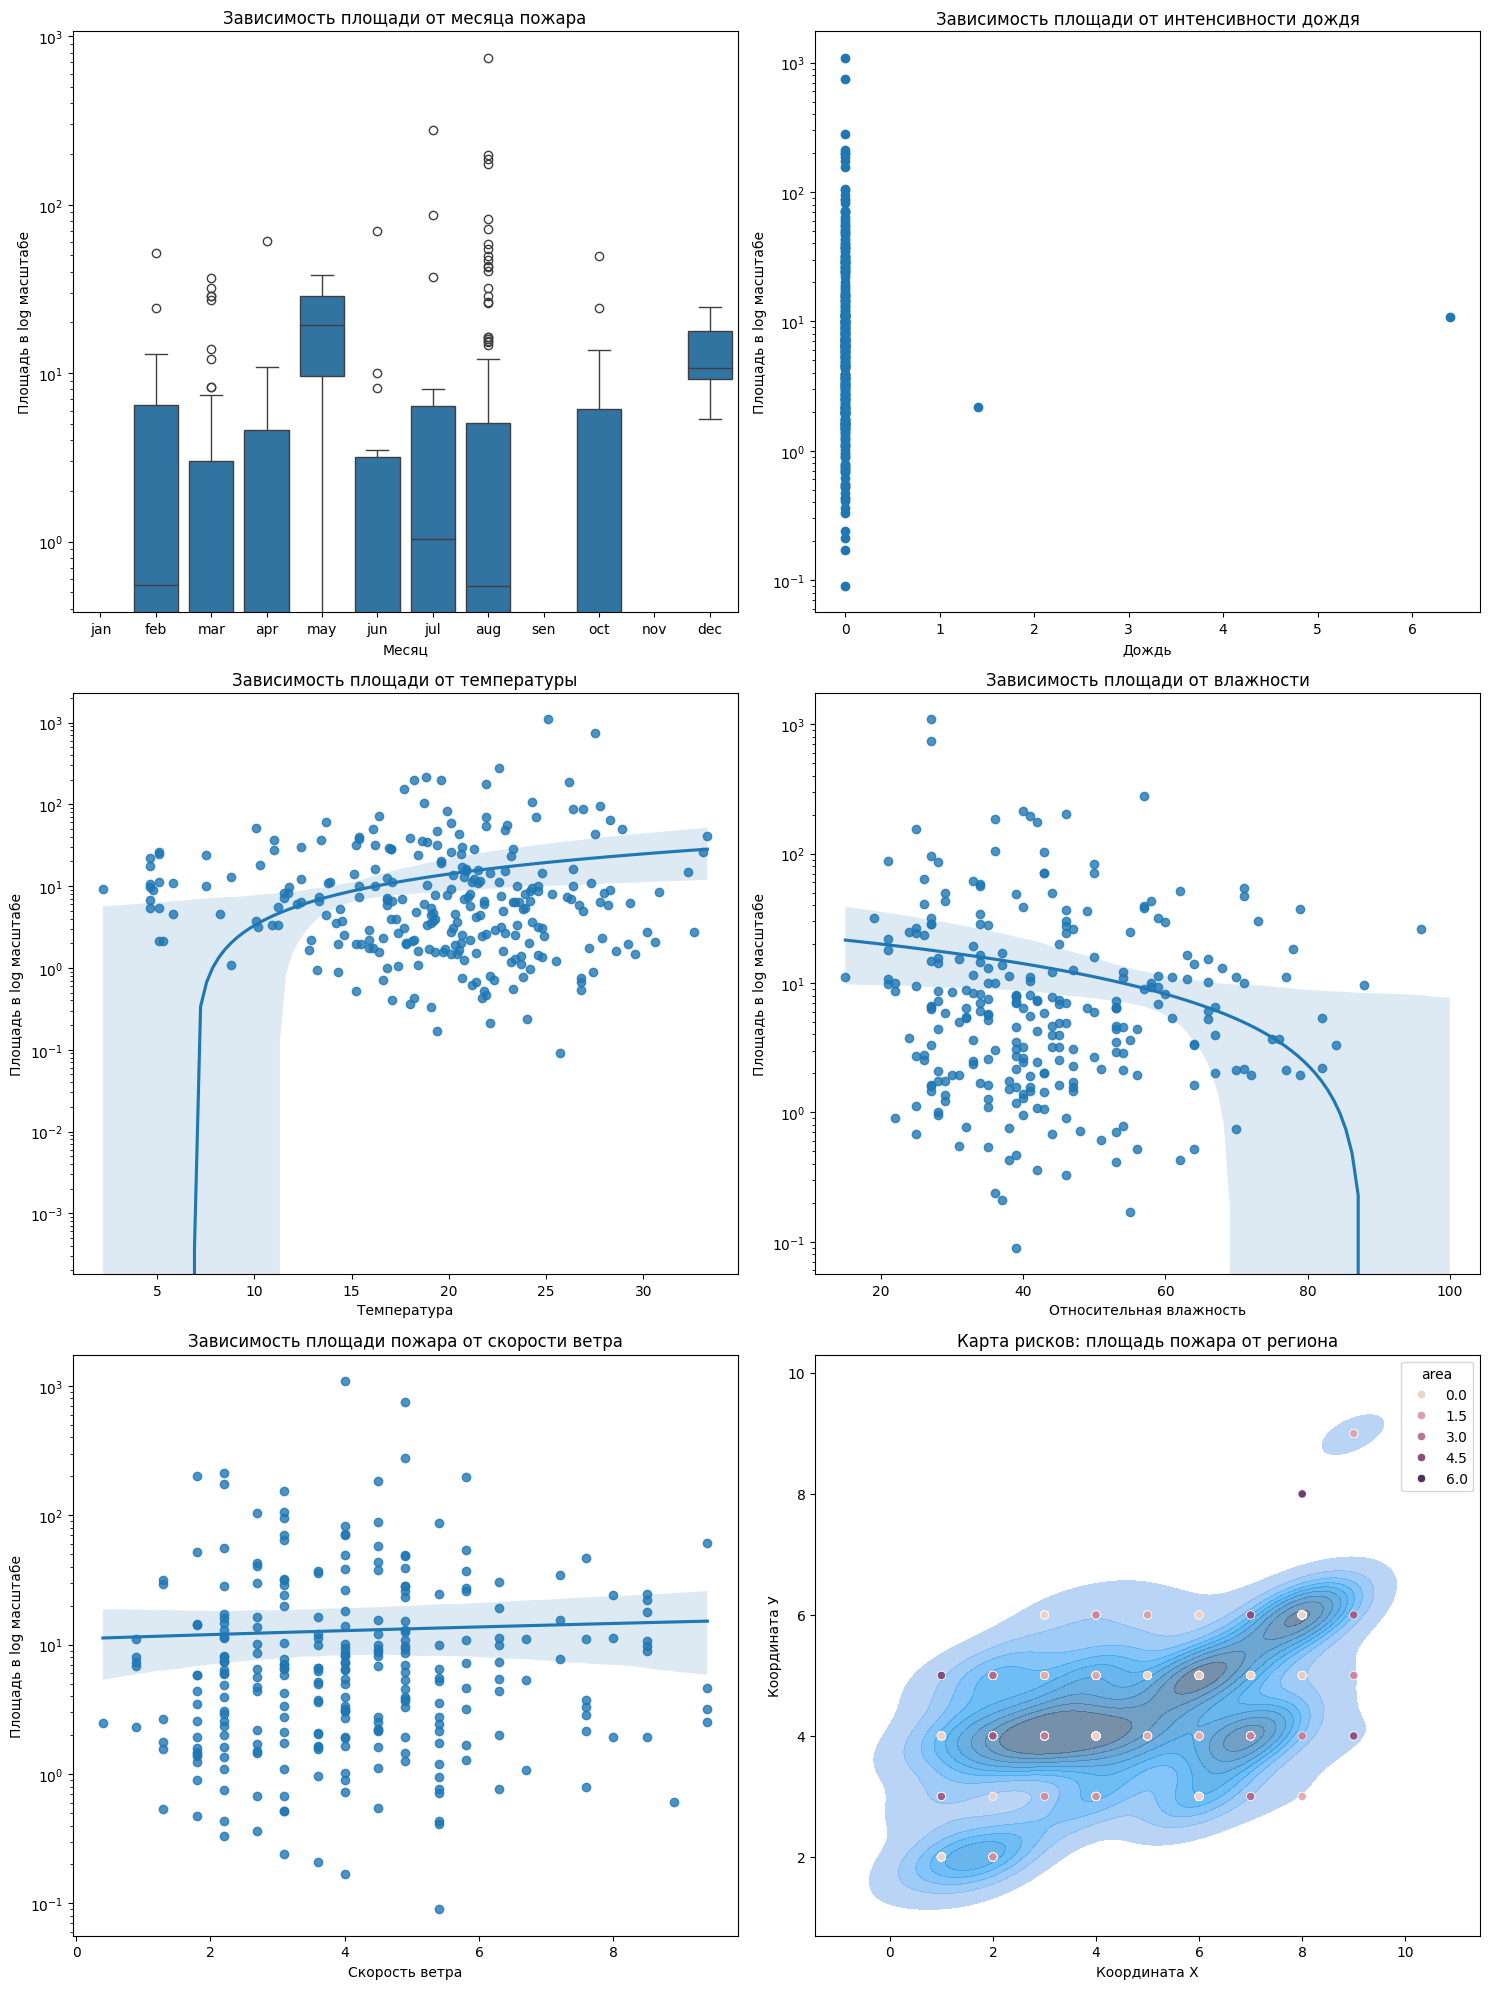

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (15, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

#1. Распредление по месяцам
x1 = data['month']
y1 = data['area']
sns.boxplot(x = x1, y = y1, ax = axs[0, 0], order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sen', 'oct', 'nov', 'dec'])
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Зависимость площади от месяца пожара')
axs[0,0].set_xlabel('Месяц')
axs[0,0].set_ylabel('Площадь в log масштабе')

#2. Зависимость от дождя
x2 = data['rain']
y2 = data['area']
axs[0, 1].scatter(x2, y2)
axs[0, 1].set_yscale('log')
axs[0, 1].set_title('Зависимость площади от интенсивности дождя')
axs[0,1].set_xlabel('Дождь')
axs[0,1].set_ylabel('Площадь в log масштабе')

#3. Зависимость от температуры
x3 = data['temp']
y3 = data['area']
sns.regplot(x = x3, y = y3, ax = axs[1, 0])
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Зависимость площади от температуры')
axs[1,0].set_xlabel('Температура')
axs[1,0].set_ylabel('Площадь в log масштабе')

#4. Зависимость от относительной влажности
x4 = data['RH']
y4 = data['area']
sns.regplot(x = x4, y = y4, ax = axs[1, 1])
axs[1, 1].set_yscale('log')
axs[1, 1].set_title('Зависимость площади от влажности')
axs[1,1].set_xlabel('Относительная влажность')
axs[1,1].set_ylabel('Площадь в log масштабе')

#5. Зависимось от ветра
x5 = data['wind']
y5 = data['area']
sns.regplot(x = x5, y = y5, ax = axs[2, 0])
axs[2, 0].set_yscale('log')
axs[2, 0].set_title('Зависимость площади пожара от скорости ветра')
axs[2,0].set_xlabel('Скорость ветра')
axs[2,0].set_ylabel('Площадь в log масштабе')

#6. Карты рисков: зависимость пожара от региона
x6 = data['X']
y6 = data['Y']
sns.kdeplot(x = x6, y = y6, ax= axs[2, 1], fill = True, alpha = 0.7)
sns.scatterplot(x = x6, y = y6, hue = np.log1p(data['area']), ax = axs[2, 1])
axs[2, 1].set_title('Карта рисков: площадь пожара от региона')
axs[2,1].set_xlabel('Координата Х')
axs[2,1].set_ylabel('Координата У')

plt.tight_layout()
plt.show()

**Выводы:**
1. Видно, что в мае и декабре самые большие по площади пожары. При этом в мае широкий разброс целевой переменной. Также стоит заметить, что в августе больше всего выбросов
2. Пожары возникают, когда нет дождя (за исключением нескольких выбросов)
3. Видна динамика: чем выше температура, тем чаще возникают пожары и тем больше их площадь
4. Аналогично, чем выше относительная влажность, тем реже и с меньшей площадью возникают лесные пожары
5. Скорость ветра слабо коррелирует с целевой переменной
6. Чаще всего пожары возникают в регионе с координатами X от 2 до 4, Y = 4, при этом площадь пожара небольшая

# **2. Обработка признаков**

Пропущенных значений нет

In [ ]:
data.sum().isna()

,0
X,False
Y,False
month,False
day,False
FFMC,False
DMC,False
DC,False
ISI,False
temp,False
RH,False


Категориальных переменных всего 2 - это month и day. Закодируем их с помощью OneHotEncoder.

In [ ]:
data.dtypes

,0
X,int64
Y,int64
month,object
day,object
FFMC,float64
DMC,float64
DC,float64
ISI,float64
temp,float64
RH,int64


In [ ]:
ohe = OneHotEncoder()
codes = ohe.fit_transform(data[['month', 'day']]).toarray()
feature_names = ohe.get_feature_names_out()
data = pd.concat([data.drop(labels = ['month', 'day'], axis = 1), pd.DataFrame(codes, columns = feature_names)], axis = 1)

In [ ]:
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# **3. Обучение модели**

In [ ]:
X = data.drop('area', axis = 1)
y = data['area']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv_score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE = {rmse:.2f}')
print(f'MAE = {mae:.2f}')
print(f'CV score = {-1*cv_score.mean():.2f}')


RMSE = 12012.94
MAE = 26.88
CV score = 47.64


Значение RMSE аномально высокие из-за выбросов. Значение МАЕ хорошо для больших пожаров, но плохо для маленьких или нулевых.

Попробуем убрать выбросы и посмотреть на значения ошибок

In [ ]:
q1 = data['area'].quantile(0.25)
q3 = data['area'].quantile(0.75)
iqr = q3 - q1
data_2 = data[(data['area'] < q3 + 1.5 * iqr) & (data['area'] > q1 - 1.5 * iqr)]

In [ ]:
X_2 = data_2.drop('area', axis = 1)
y_2 = data_2['area']

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.2, random_state = 42)

RMSE = 4.00
MAE = 2.95
CV score = 3.94


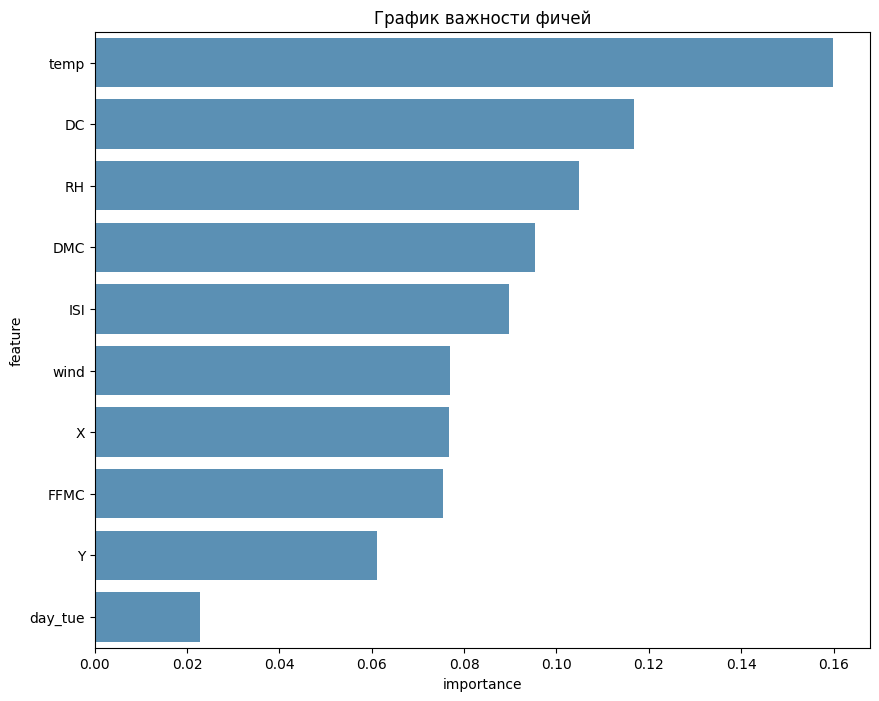

In [ ]:
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train_2, y_train_2)
y_pred_2 = model.predict(X_test_2)

cv_score_2 = cross_val_score(model, X_train_2, y_train_2, cv = 5, scoring = 'neg_root_mean_squared_error')

rmse_2 = root_mean_squared_error(y_test_2, y_pred_2)
mae_2 = mean_absolute_error(y_test_2, y_pred_2)
print(f'RMSE = {rmse_2:.2f}')
print(f'MAE = {mae_2:.2f}')
print(f'CV score = {-1*cv_score_2.mean():.2f}')

#График важности фичей
feature_imp = pd.DataFrame({
    'feature': X_train_2.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending = False)

plt.figure(figsize=(10, 8))
sns.barplot(data = feature_imp.head(10), x = 'importance', y = 'feature',alpha = 0.8)
plt.title('График важности фичей')
plt.show()

RMSE и MAE стали значительно ниже, но недостаточно (из-за большого количества нулей в датасете).  Топ фичи - это температура и DC, логично лидируют, так как сухость/жара провоцируют пожары

Воспользуемся градиентным бустингом **XGBoost**

RMSE = 4.39
MAE = 3.04
CV score 4.33


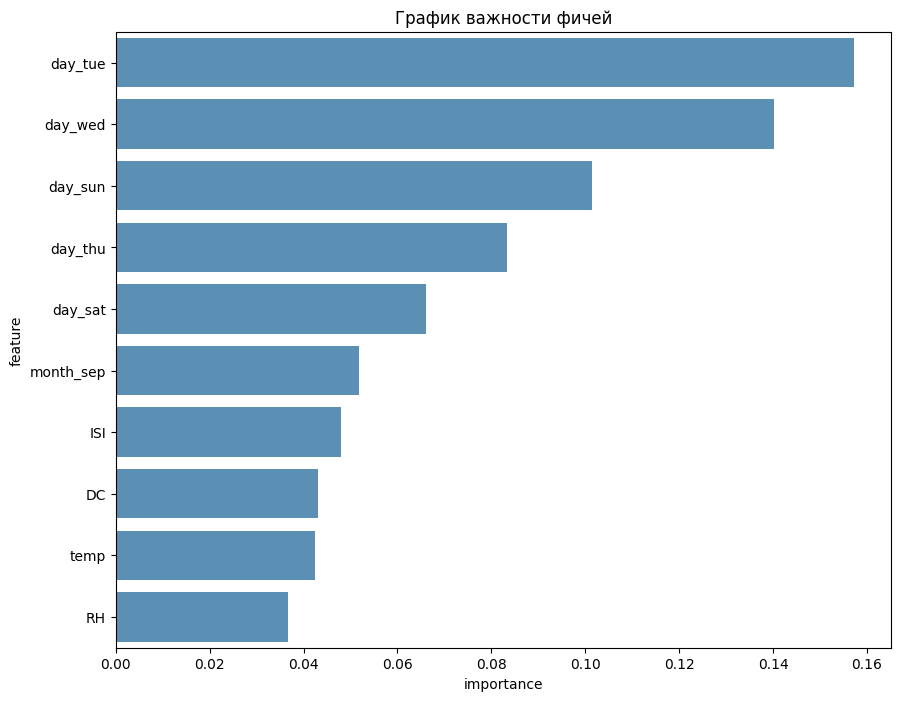

In [ ]:
model = xgb.XGBRegressor(verbosity = 0, eval_metric = 'rmse', random_state = 42)
model.fit(X_train_2, y_train_2)
y_pred_2 = model.predict(X_test_2)

cv_score = cross_val_score(model, X_train_2, y_train_2, cv = 5, scoring = 'neg_root_mean_squared_error')

rmse = root_mean_squared_error(y_test_2, y_pred_2)
mae = mean_absolute_error(y_test_2, y_pred_2)
print(f'RMSE = {rmse:.2f}')
print(f'MAE = {mae:.2f}')
print(f'CV score {-1*cv_score.mean():.2f}')

#График важности фичей
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending = False)

plt.figure(figsize=(10, 8))
sns.barplot(data = feature_imp.head(10), x = 'importance', y = 'feature',alpha = 0.8)
plt.title('График важности фичей')
plt.show()

Он показал результаты немного хуже, чем Random Forest. Скорее всего, из-за малого количества решающих пней в градиентном бустинге. Также для него наиболее важными оказались другие фичи - дни недели и месяц. Подберем гиперпараметры, чтобы улучшить значения метрик

# 4. **Подбор гиперпараметров**

Подберем гиперпараметры с помощью GridSearchCV

In [ ]:
params = {
    'n_estimators': [300, 500, 700, 900, 1100],
    'max_depth': [4, 6, 8, 10],
    'learning_rate':[0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'reg_alpha': [4, 6, 8, 10],
    'reg_lambda': [4, 6, 8, 10]
}
cross_val = GridSearchCV(xgb.XGBRegressor(verbosity = 0, random_state = 42), params, cv= 5, scoring = 'neg_root_mean_squared_error')
cross_val.fit(X_train_2, y_train_2)

print(f'Best params: {cross_val.best_params_}')
print(f'CV_score = {-1*cross_val.best_score_:.2f}')

Best params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 10, 'reg_lambda': 6, 'subsample': 1.0}
CV_score = 3.78


После подбора гиперпараметров с помощью гридовой сетки метрики стали лучше

In [ ]:
model = xgb.XGBRegressor(**cross_val.best_params_, verbosity = 0, eval_metric = 'rmse', random_state = 42)
model.fit(X_train_2, y_train_2)
y_pred_2 = model.predict(X_test_2)

rmse = root_mean_squared_error(y_test_2, y_pred_2)
mae = mean_absolute_error(y_test_2, y_pred_2)
print(f'RMSE = {rmse:.2f}')
print(f'MAE = {mae:.2f}')

RMSE = 3.85
MAE = 2.79


Воспользуемся библиотекой **Optuna** для более точного подбора гиперпараметров

In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
def optimize_xgboost(trial, X_train, y_train):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 2, 10),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
      'subsample': trial.suggest_float('subsample', 0.2, 1.0),
      'reg_alpha': trial.suggest_float('reg_alpha', 1, 10),
      'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
      'verbosity': 0,
      'eval_metric': 'rmse',
      'random_state': 42
  }

  model = xgb.XGBRegressor(**params)
  scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')
  return -scores.mean()

In [ ]:
class EarlyStoppingExceeded(Exception):
    pass

def early_stopping_callback(study, trial):
    window_size = 20
    min_delta = 0.01
    patience = 3

    if not hasattr(study, '_early_stop_counter'):
        study._early_stop_counter = 0

    if len(study.trials) < window_size:
        return

    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    if len(completed_trials) < window_size:
        return

    best_in_window = min(t.value for t in completed_trials[-window_size:])
    global_best = study.best_value

    if best_in_window >= global_best - min_delta:
        study._early_stop_counter += 1
        print(f"⚠️ Потенциальная остановка ({study._early_stop_counter}/{patience}): "
              f"Лучшее в окне {best_in_window:.4f} vs глобальное {global_best:.4f}")

        if study._early_stop_counter >= patience:
            print(f"🛑 Вызываем остановку: нет улучшений > {min_delta} в последних {window_size*patience} trials")
            raise EarlyStoppingExceeded()
    else:
        study._early_stop_counter = 0

In [ ]:
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = 42))

# Добавляем лучший вариант из GridSearch как начальную точку
#study.enqueue_trial(cross_val.best_params_)
try:
  study.optimize(lambda trial: optimize_xgboost(trial, X_train, y_train), n_trials = 150, timeout = 600, show_progress_bar = False, callbacks = [early_stopping_callback])
except:
  print('Рання остановка')
model = xgb.XGBRegressor(**study.best_params)
model.fit(X_train_2, y_train_2)
y_pred = model.predict(X_test_2)

cv_scores = cross_val_score(model, X_train_2, y_train_2, cv = 5, scoring = 'neg_root_mean_squared_error')

print(f'RMSE = {root_mean_squared_error(y_test_2, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test_2, y_pred):.2f}')
print(f'CV scores: {-1*cv_scores.mean():.2f}')

[I 2025-08-15 08:52:54,658] A new study created in memory with name: no-name-4e3ee17b-cbe0-431a-a21f-115d566277e7
[I 2025-08-15 08:52:57,128] Trial 0 finished with value: 55.891677704650206 and parameters: {'n_estimators': 406, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.6789267873576292, 'reg_alpha': 2.4041677639819286, 'reg_lambda': 2.403950683025824}. Best is trial 0 with value: 55.891677704650206.
[I 2025-08-15 08:52:58,225] Trial 1 finished with value: 53.8872013971252 and parameters: {'n_estimators': 105, 'max_depth': 9, 'learning_rate': 0.18432335340553055, 'subsample': 0.7664580622368364, 'reg_alpha': 1.185260448662222, 'reg_lambda': 9.72918866945795}. Best is trial 1 with value: 53.8872013971252.
[I 2025-08-15 08:52:59,824] Trial 2 finished with value: 54.23434752027386 and parameters: {'n_estimators': 841, 'max_depth': 3, 'learning_rate': 0.06272924049005918, 'subsample': 0.34672360788274703, 'reg_alpha': 3.7381801866358395, 'reg_lambda': 5.722807884

⚠️ Потенциальная остановка (1/3): Лучшее в окне 38.8680 vs глобальное 38.8680


[I 2025-08-15 08:53:32,659] Trial 20 finished with value: 39.14428182941646 and parameters: {'n_estimators': 165, 'max_depth': 5, 'learning_rate': 0.013821972170467794, 'subsample': 0.2141164452988133, 'reg_alpha': 8.835652010367458, 'reg_lambda': 4.874068746132496}. Best is trial 19 with value: 38.86796306169991.


⚠️ Потенциальная остановка (2/3): Лучшее в окне 38.8680 vs глобальное 38.8680


[I 2025-08-15 08:53:33,286] Trial 21 finished with value: 39.40904672781187 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.014903133710052488, 'subsample': 0.2269030306154167, 'reg_alpha': 8.80961120399933, 'reg_lambda': 4.334292037695386}. Best is trial 19 with value: 38.86796306169991.


⚠️ Потенциальная остановка (3/3): Лучшее в окне 38.8680 vs глобальное 38.8680
🛑 Вызываем остановку: нет улучшений > 0.01 в последних 60 trials
Рання остановка
RMSE = 3.91
MAE: 2.84
CV scores: 3.75


Результаты показывают прогресс: RMSE = 4.39 для базового градиентного бустинга и RMSE = 3.91 - для тюнингованого. XGBoost после подбора гиперпараметров превзошел Random Forest.